# Tutorial on Levinthal (1997)

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by Dan Levinthal, published in 1997 in Management Science. 

This tutorial provides a barebones description of the model. If you want to explore a more flexible version or explore how different agents or bandit distributions would affect Dan's results please employ Maciej Workiewicz's code (https://www.maciejworkiewicz.com/coding). There you will find code on how to replicate also other seminal papers on NK landscapes.

**Reference:** Levinthal, D. A. (1997). Adaptation on rugged landscapes. Management science, 43(7), 934-950.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>
<script type="text/javascript" src="https://raw.github.com/kmahelona/ipython_notebook_goodies/master/ipython_notebook_toc.js">

# Basic building blocks
Below I introduce the code for searching in NK landscape, equivalent to the one from Levithnal (1997)
For this I create a agent class. The agent is very simple, it just knows the percentage of time it can make a long jump. 
Levinthal includes other aspects like myopia but this is not in the code at the moment. 

## 1. Landscape
An NK landscape outputs a payoff value for an input policy. It is is equivalent to getting an elevation value after providing the longitude and latitude in a map. That is the reason why it is called a landscape. However, the inputs of an NK landscape are binary thus the analogy does not go to far.  
Overall, the landscape receives a policy and outputs a payoff for this policy. The policy consists in N binary values (e.g. [1,0,1]). The payoff depends on the value of K of the NK model. 

K represents the amount of interdependencies that are linked to the performance of each of the N variables. In an environment where K=0, then the performance of the policy value depends only on its own value, if 0 then x0 if 1 then x1. It does not depend on the other N-1 elements. If K > 0 then the payoff for this policy element depends on the value of some of the N-1 elements of the policy. If K = N-1 then the payoff of this policy element depends on the value of all the other N-1 policy element. The higher the K the higher the complexity of the interrelationships when calculating the performance of each policy.    
### 1.1 Create Dependencies
The first step to create a landscape is creating the dependency matrix. Here one takes N and K and fills an N by N matrix with 1s in the diagonal and N*K 1s in the off diagonal. On each row there are K 1s in the off-diagonal, and a 1 in the diagonal. 

### 1.2 Fitness contribution
Having the interdependency matrix. We can create the fitness contributions. These basically determine the payoff each policy element receives. There are in total N different sets of fitness contribution functions. Each of the N sets has 2^k+1 different values for all the combinations of the policies that matter for the policy element at hand.  
The fitness contribution is created by filling a list with N dictionaries. Each dictionary has as key value a combination of policies that affect the payoff of the policy element (e.g. '010') and as value a draw from an uniform distribution.  

### 1.3 Payoff
The fitness contributions are used to calculate the total payoff of each policy. For this we need a way of taking a policy and determining the interactions that each policy element makes in order to estimate its payoff contribution.   
This requires several steps. Firts we need to obtain the keys for the fitness contributions. that is we take a policy (e.g. [1,0,1]) and determine for every policy element the key value for the fitness contribution.  
  
Let's imagine that the dependency matrix is:  
  
|1 1 0|  
|0 1 1|  
|0 1 1|  

From Levinthal (1997), we would see that the first key value is [1,0], the second [0,1], and the third [0,1]. In the code below, the functions transfor_matrix and transform_row are in charge of making the translation from a policy to the key values. 
  
After having the key values, we can calculate the performance of each policy element by addressing the fitness contribution list of each element, and then averaging them. The total payoff for one fitness contribution is this average. 

### 1.4 Calculate landscape
After having a function that calculate the performance of one policy we can calculate the full landscape by running a for-loop over each policy value. 

### 1.6 Landscape initiation
To initiate a landscape one just needs to give the N and K value. The landscape is created with the use of the reset function.

### 1.5 Reset
The reset function creates a landscape by first building the dependency matrix, then the fitness contributions, and lastly the full-landscape from the prior two. For doing this it just requires the N and K values given at the initiation of the class. 

### 1.6 Summary
The summary function outputs the maximum, minimum, and number of peaks in the landscape. 

### 1.7 Miscellaneous functions  
#### 1.7.1 Int2List
This function translates an integer value to a list of that value in binary.  
For example 5 is translated in to [0,1,0,1] in the case of N=4 or [1,0,1] in case N = 3

#### 1.7.2 List2Int
This function does the opposite, takes a list policy and outputs its integer value. That is it takes say [1,1,0,0] and outputs 12.

#### 1.7.3 Transform Matrix
Handles the transformation of a policy into the key values for estimating its payoff. For this it uses transform_row for every policy element. 

#### 1.7.4 Transform Row
Uses the policy and interacts it with a row of the dependency matrix. For example if the policy is  [1,0,1] and the row is [0,1,1] then the output is [0,1]. If the row was [1,0,0] then the output would be [1]. The number of items in the output depents on the number of 1s in the row. This in turn is determined by the K value.  
This transformation gives always the same value and thus can be used with the fitness contribution to estimate the payoff for each policy element.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def int2list(pol_int, n):
    pol_str = bin(pol_int)
    policy = [int(pol) for pol in pol_str[2:]]
    if len(policy) < n: policy = [0]*(n-len(policy))+policy
    return(policy)

def list2int(pol_list):
    pol_list.reverse()
    pol_int = np.sum([(2**j)*pol_list[j] for j in range(len(pol_list))])
    return(pol_int)

def transform_matrix(policy, dep_mat):
    int_mat = [transform_row(policy, dep_mat[i]) for i in range(len(dep_mat))]
    return(int_mat)

def transform_row(policy, dep_row):
    interact_row = [policy[i] for i in range(len(policy)) if dep_row[i] == 1]
    trans_pol = list2int(interact_row)
    return(bin(trans_pol))

class landscape:
    def __init__(self,n,k):
        self.n = n
        self.k = k
        self.reset()
    def calc_landscape(self):
        land = []
        for i in range(2**self.n):
            pol_list = int2list(i,self.n)
            land.append({'int_pol':i, 'policy': np.asarray(pol_list), 'payoff':self.payoff(pol_list)})
        self.lands = pd.DataFrame(land)
    def create_dependencies(self):
        self.dep_mat = np.zeros((self.n,self.n)).astype(int)
        for i in range(self.n):
            inter = np.random.choice([1]*self.k+[0]*(self.n-self.k-1), replace = False, size = self.n-1)
            for j in range(self.n):
                if i != j: 
                    self.dep_mat[i][j] = inter[0]
                    inter = inter[1:]
                else: self.dep_mat[i][i] = 1
    def fitness_contribution(self):
        self.fit_con = []
        for i in range(self.n): 
            epi_row = {bin(j): np.random.random() for j in range(2**sum(self.dep_mat[i]))}
            self.fit_con.append(epi_row)
    def payoff(self, policy):
        keys = transform_matrix(policy, self.dep_mat)
        pay = np.sum([self.fit_con[i][keys[i]]/len(policy) for i in range(len(policy))])
        return(pay)
    def reset(self):
        self.create_dependencies()
        self.fitness_contribution()
        self.calc_landscape()   
    def summary(self):
        max_global = max(self.lands.payoff)
        min_global = min(self.lands.payoff)
        num_peaks = 0
        for i in range(self.lands.shape[0]):
            randomized_neighbors = find_neighbors(self.lands.policy[i])
            if self.lands.loc[i, "payoff"] > np.max(self.lands.loc[randomized_neighbors, "payoff"]): num_peaks += 1
        return([max_global, min_global, num_peaks])

## 2. Agents

### 2.1 Initiation
The agent is created by giving the probability of making a long jump instead of searching its neighbors. Everything else is done through its search function.

### 2.2 Search
The search function receives a landscape and the number of periods it has to search the landscape. On every periods, it has the opportunity of making a long jump and staying in the position if it has a higher payoff or searching the neighboring positions.  
The agent decides to move to a new position only if the payoff is higher than the current payoff. Any change of position is logged into a short log, and even if there is no change, the current position is logged into a longer log. If the global maximum is found, then the agent stores a 1 and the period when the global maximum was reached.  

### 2.3 Find Neighbors
The main form of movement for the agent is local search. This implies moving to each neighboring position and staying in the first that gives a higher payoff. In order to do this the agent needs to find its neighbors. This can be done in several ways, here what we do is to morph the current position by flipping one policy element and storing it as a neighbor. We do this for every policy element to make a list of neighbors. We randomize the order of neighbors to avoid bias and use this for local search. 



In [2]:
def find_neighbors(policy):
    policy = (policy) #policy changed 
    neighbors = []
    random_order = np.random.choice(range(len(policy)), replace = False, size = len(policy))
    for i in random_order:
        neighbor = list(policy)
        if policy[i] == 1: neighbor[i] = 0
        else: neighbor[i] = 1
        neighbors.append(list2int(neighbor))
    return(neighbors)

class agent:
    def __init__(self, long_jump):
        self.long_jump = long_jump
    def search(self, lands, num_periods):
        current_row = lands.loc[np.random.choice(lands.shape[0]),:]
        global_max = lands.loc[np.argmax(lands.payoff),:]
        log_short = [current_row]
        log_long = [current_row]
        for j in range(num_periods):
            if np.random.choice(["Walk", "Jump"], p = [1-long_jump, long_jump]) == "Jump": 
                proposed_row = np.random.choice(lands.shape[0])
            else:
                randomized_neighbors = find_neighbors(current_row.policy)
                for proposed_row in randomized_neighbors:
                    if lands.payoff[proposed_row] > current_row.payoff: break # weird but works
            if lands.payoff[proposed_row] > current_row.payoff:
                current_row = lands.loc[proposed_row,:]
                log_short.append(current_row) #stores changes
            log_long.append(current_row) #stores every period
            if current_row.int_pol == global_max.int_pol & j < num_periods-1: 
                for k in range(num_periods-j-1): log_long.append(current_row) # makes all dataframes the same length
                break # avoid doing irrelevant calculations
        log_short.append(global_max) # add global max for comparison later on
        log_long.append(global_max) # add global max for comparison later on
        reached_max = 1*(current_row.int_pol == global_max.int_pol)
        return([reached_max, len(log_short)-1, j, pd.DataFrame(log_short), pd.DataFrame(log_long)])


## 3. Simulation
Having the agent and the landscape it is turn to perform the simulation. For this we use a function. This function takes the nubmer of repetitions, the number periods to simulate and the Agent and Landscape. It runs the simulation through a simple for-loop reseting the landscape on every loop. At the end it outputs, the number of times the agents found the global maximum, the number of movements the agent did, the average periods when the maximum was reached, and an array with the average payoffs received on every period. 

In [3]:
def run_simulation(num_reps, num_periods, Alice, Environment):
        all_reached_max = 0
        all_num_steps = 0
        all_num_trials = 0
        all_payoffs = np.zeros(num_periods+2)
        for j in range(num_reps):
            Environment.reset() # 23 of 35s
            reached_max, n_step, n_trial, o_short, o_long = Alice.search(lands = Environment.lands, num_periods = num_periods) # 7.5 of 33s
            all_reached_max += reached_max
            all_num_steps += n_step
            all_num_trials += n_trial
            all_payoffs = np.add(all_payoffs, o_long.payoff)
        return([all_reached_max, all_num_steps, all_num_trials, all_payoffs])

# Run Simulation
Below we run the simulation once and show the steps followed by one agent while searching the landscape. 

In [4]:
n = 6
k = 2
num_periods = 50
num_reps = 1000
long_jump = 0.1
Environment = landscape(n,k)    
Alice = agent(long_jump = long_jump)
reached_max, n_step, n_trial, output_short, output_long = Alice.search(Environment.lands, num_periods)
output_short

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


,int_pol,payoff,policy
33,33,0.760843,"[1, 0, 0, 0, 0, 1]"
37,37,0.785568,"[1, 0, 0, 1, 0, 1]"
37,37,0.785568,"[1, 0, 0, 1, 0, 1]"


Additionally we run a simulation 1000 times to show the average form in which the agents explore the landscape. We print the percentage of times it reaches the global maximum, the number of movements done before the total number of periods were reached, the number of periods needed to find the maximum, and the time required to make the simulation. On average 50% of the agents reached the global maximum and they reached it around period 36. 

In [5]:
import time
start_time = time.time()
all_reached_max, all_num_steps, all_num_trials, all_payoffs= run_simulation(num_reps, num_periods, Alice, Environment)
print(100*all_reached_max/num_reps)
print(all_num_steps/num_reps)
print(all_num_trials/num_reps)
print(round(time.time()-start_time,1))

47.1
3.848
36.963
40.7


We also plot the growth in payoff as the agents search the landscape. The last value is the average of the global maxima. Clearly, the search process is still distante to reaching the highest peak on every search ocassion. 

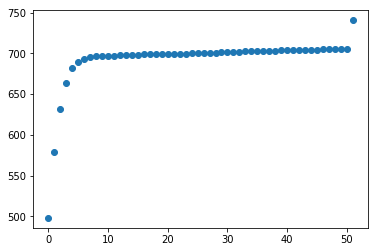

In [6]:
plt.scatter(range(num_periods+2), all_payoffs[:num_periods+2])

Below we time the simulations to have an understanding of what part takes the longest, the landscape building, or search. At low N and K, the landscape takes longer than the search. At higher N and K values, the opposite is true. 

In [7]:
Environment = landscape(n,k)    
start_time = time.time()
for i in range(num_reps): 
    Environment.reset() # 90% from cal_lands
print(time.time()-start_time)

start_time = time.time()
for i in range(num_reps): Alice.search(Environment.lands, num_periods) # searches 1 landscape only
print(time.time()-start_time)

10.103179931640625
22.66103506088257


Finally we create 1000 landscapes and see their characteristics. Although making 1000 landscapes takes around 8 seconds, estimating their characteristics takes one order of magnitude longer. This is not a crucial step so I have not optimized it, yet.

0.7378135692270913
0.25953060985107645
3.568
1
10
85.87183833122253


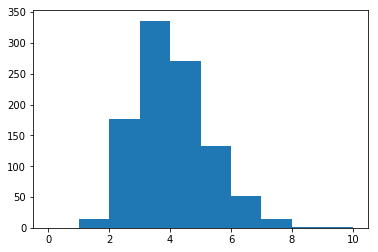

In [8]:
Environment = landscape(n,k)    
start_time = time.time()
all_max = []
all_min = []
all_num_peaks = []
for i in range(num_reps): 
    Environment.reset() # 90% from cal_lands
    max_val, min_val, peaks = Environment.summary()
    all_max.append(max_val)
    all_min.append(min_val)
    all_num_peaks.append(peaks)
print(np.mean(all_max))
print(np.mean(all_min))
print(np.mean(all_num_peaks))
print(min(all_num_peaks))
print(max(all_num_peaks))
plt.hist(all_num_peaks, bins=10, range=(0, 10))
print(time.time()-start_time)

Levinthal (1997) includes more analyzes. These are yet to be implmented here. In the future, I will add the myopic jumping as this is important for the paper. 

**Note:** The code below produced the table of contents.

In [9]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>